In [1]:
input_params = ["time_add_tnf", "duration_add_tnf", "concentration_tnf", "tumor_radius"]
cell_states = ["alive", "apoptotic", "necrotic"]

##### Imports

In [2]:
import json
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import platform
import os
import socket

In [3]:
if 'mac' in platform.platform():
    DATA_DIR = "/Users/marco/phd/meta-model-physiboss/data/"
elif 'mustafar' in socket.gethostname():
    DATA_DIR = "/mnt/data/"
else:
   raise ValueError("no known data directory")

##### Read Files

In [4]:
INPUT_DIR = os.path.join(DATA_DIR, "input_parameters")

# for each json file in the input directory, read the file into a dictionary
input_parameters = {
    "time_add_tnf": [],
    "duration_add_tnf": [],
    "concentration_tnf": [],
    "tumor_radius": [],
}

files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".json")]
files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[-1]))
print(files)

save_time = None
for file in files:
    with open(os.path.join(INPUT_DIR, file), "r") as f:
        j = json.load(f)
        input_parameters["time_add_tnf"].append(j["time_add_tnf"]["value"])
        input_parameters["duration_add_tnf"].append(j["duration_add_tnf"]["value"])
        input_parameters["concentration_tnf"].append(j["concentration_tnf"]["value"])
        input_parameters["tumor_radius"].append(j["tumor_radius"]["value"])
        if save_time is None : save_time = j["save_time"]["value"]
        else: assert save_time == j["save_time"]["value"]

print(save_time)

['input_parameters_0.json', 'input_parameters_1.json', 'input_parameters_2.json', 'input_parameters_3.json', 'input_parameters_4.json', 'input_parameters_5.json', 'input_parameters_6.json', 'input_parameters_7.json', 'input_parameters_8.json', 'input_parameters_9.json', 'input_parameters_10.json', 'input_parameters_11.json', 'input_parameters_12.json', 'input_parameters_13.json', 'input_parameters_14.json', 'input_parameters_15.json', 'input_parameters_16.json', 'input_parameters_17.json', 'input_parameters_18.json', 'input_parameters_19.json', 'input_parameters_20.json', 'input_parameters_21.json', 'input_parameters_22.json', 'input_parameters_23.json', 'input_parameters_24.json', 'input_parameters_25.json', 'input_parameters_26.json', 'input_parameters_27.json', 'input_parameters_28.json', 'input_parameters_29.json', 'input_parameters_30.json', 'input_parameters_31.json', 'input_parameters_32.json', 'input_parameters_33.json', 'input_parameters_34.json', 'input_parameters_35.json', '

In [5]:
CELL_DATA_DIR = os.path.join(DATA_DIR, "cell_data")

# for each .json.gz file, extract the json file and read it into a dictionary
cell_data = {
    "alive": [],
    "apoptotic": [],
    "necrotic": [],
}
files = [f for f in os.listdir(CELL_DATA_DIR) if f.endswith(".json.gz")]
files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[-1]))
print(files)

n_steps = None
for file in files:
    with gzip.open(os.path.join(CELL_DATA_DIR, file), "rb") as f_unzipped:
        j_bytes = f_unzipped.read()
        j_str = j_bytes.decode("utf-8")
        j = json.loads(j_str)
        alive, apoptotic, necrotic = [], [], []
        for k, v in j.items():
            cp = v["current_phase"]
            alive.append(cp.count("alive"))
            apoptotic.append(cp.count("apoptotic"))
            necrotic.append(cp.count("necrotic"))
        cell_data["alive"].append(alive)
        cell_data["apoptotic"].append(apoptotic)
        cell_data["necrotic"].append(necrotic)

        if n_steps is None: n_steps = len(j.keys())
        else: assert n_steps == len(j.keys())

print(n_steps)

['cell_data_0.json.gz', 'cell_data_1.json.gz', 'cell_data_2.json.gz', 'cell_data_3.json.gz', 'cell_data_4.json.gz', 'cell_data_5.json.gz', 'cell_data_6.json.gz', 'cell_data_7.json.gz', 'cell_data_8.json.gz', 'cell_data_9.json.gz', 'cell_data_10.json.gz', 'cell_data_11.json.gz', 'cell_data_12.json.gz', 'cell_data_13.json.gz', 'cell_data_14.json.gz', 'cell_data_15.json.gz', 'cell_data_16.json.gz', 'cell_data_17.json.gz', 'cell_data_18.json.gz', 'cell_data_19.json.gz', 'cell_data_20.json.gz', 'cell_data_21.json.gz', 'cell_data_22.json.gz', 'cell_data_23.json.gz', 'cell_data_24.json.gz', 'cell_data_25.json.gz', 'cell_data_26.json.gz', 'cell_data_27.json.gz', 'cell_data_28.json.gz', 'cell_data_29.json.gz', 'cell_data_30.json.gz', 'cell_data_31.json.gz', 'cell_data_32.json.gz', 'cell_data_33.json.gz', 'cell_data_34.json.gz', 'cell_data_35.json.gz', 'cell_data_36.json.gz', 'cell_data_37.json.gz', 'cell_data_38.json.gz', 'cell_data_39.json.gz', 'cell_data_40.json.gz', 'cell_data_41.json.gz', '

49


##### Build data and save

In [6]:
data = pd.DataFrame({
    **input_parameters,
    **cell_data
}).reset_index()

# add the index of the input parameters
data['index_input_params'] = data.groupby(input_params).ngroup()

In [7]:
len(data)

3520

In [8]:
data.to_csv("data/data.csv", index=False)

##### Aggregate and generate median, mean, and std data

In [9]:
for cs in cell_states:
    data[cs] = data[cs].map(lambda c: np.array(c, dtype=np.int32))

In [10]:
data_agg = pd.concat([
    data.groupby(input_params).agg({
        cs: lambda d: list(np.mean(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_mean" for cs in cell_states}),
    data.groupby(input_params).agg({
        cs: lambda d: list(np.median(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_median" for cs in cell_states}),
    data.groupby(input_params).agg({
        cs: lambda d: list(np.std(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_std" for cs in cell_states}),
], axis=1).reset_index().reset_index().copy()

In [11]:
len(data_agg)

3520

In [12]:
data_agg.to_csv("data/data_agg.csv", index=False)

##### Do the same for the "diff"

In [13]:
data_agg_diff = data.copy()

for cs in cell_states:
    data_agg_diff[cs] = data_agg_diff[cs].map(lambda c: np.hstack([c[0], np.diff(c)]))

In [14]:
data_agg_diff = pd.concat([
    data_agg_diff.groupby(input_params).agg({
        cs: lambda d: list(np.mean(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_diff_mean" for cs in cell_states}),
    data_agg_diff.groupby(input_params).agg({
        cs: lambda d: list(np.median(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_diff_median" for cs in cell_states}),
    data_agg_diff.groupby(input_params).agg({
        cs: lambda d: list(np.std(d.tolist(), axis=0)) for cs in cell_states
    }).rename(columns={cs: f"{cs}_diff_std" for cs in cell_states}),
], axis=1).reset_index().reset_index()

In [15]:
len(data_agg_diff)

3520

In [16]:
data_agg_diff.to_csv("data/data_agg_diff.csv", index=False)

## Exploration

#### Input parameters

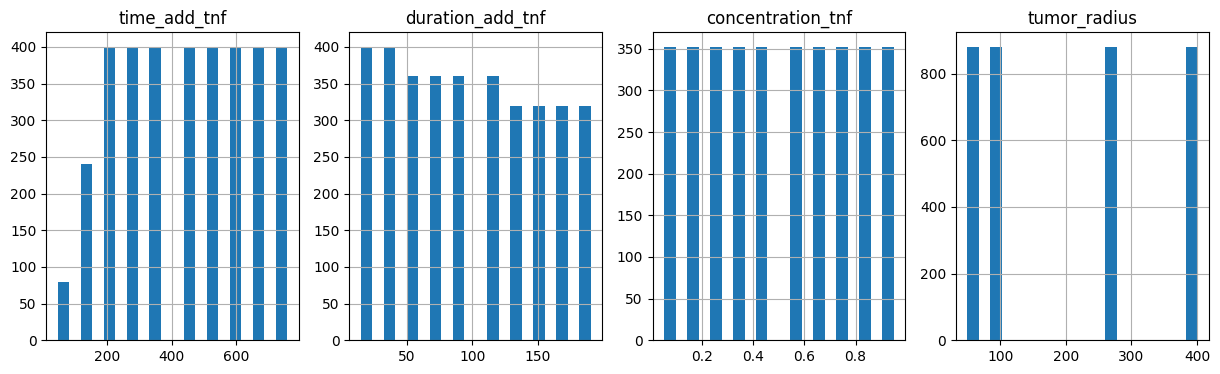

In [17]:
_, axs = plt.subplots(1, len(input_params), figsize=(15, 4))
for i, ip in enumerate(input_params):
    data[ip].hist(bins=20, ax=axs[i])
    axs[i].set_title(ip)
plt.show()

#### Cell states

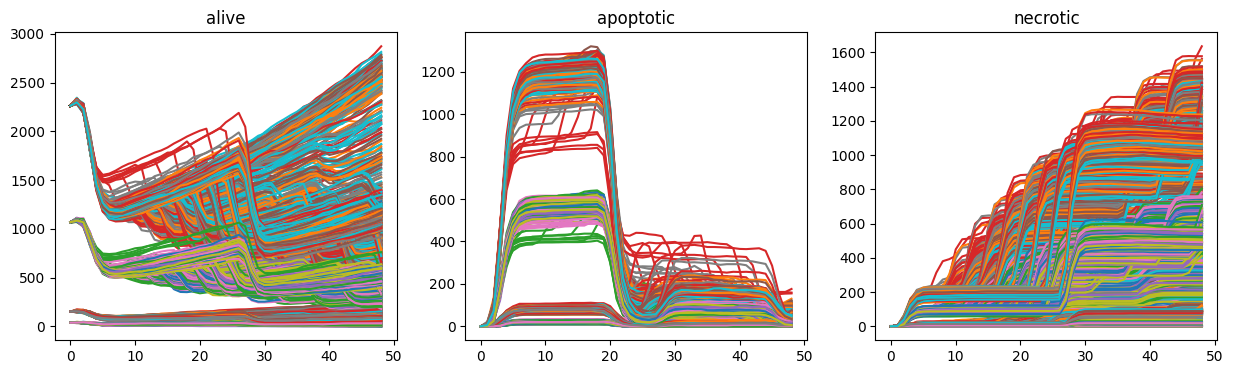

In [18]:
_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data[cs]:
        axs[i].plot(a)
    axs[i].set_title(cs)
plt.show()

#### Aggregated cell states statistics

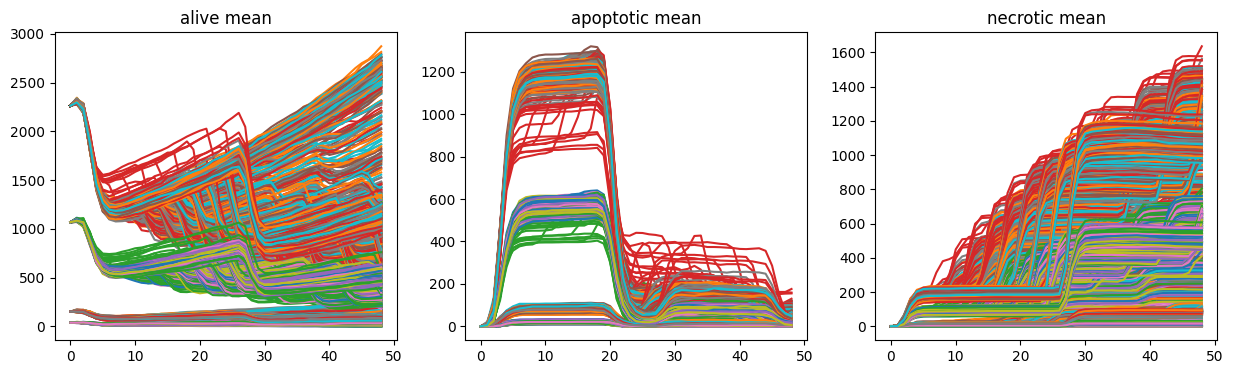

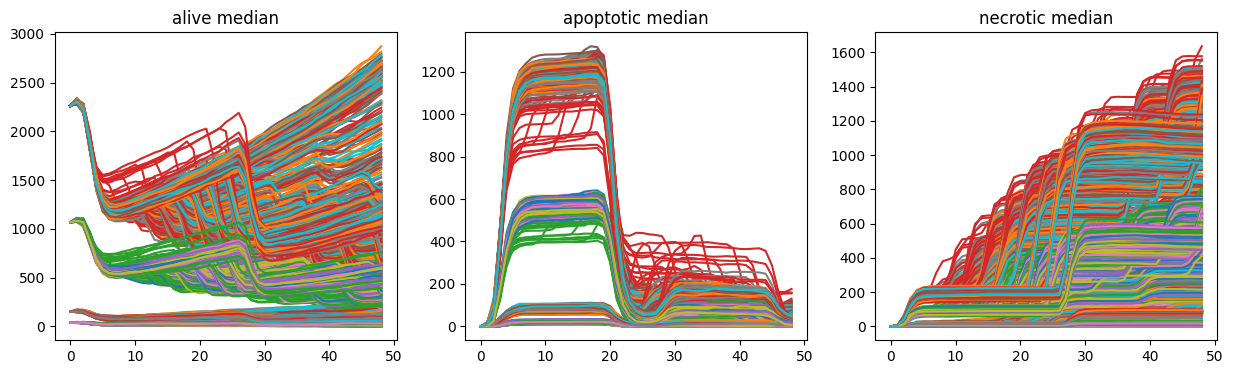

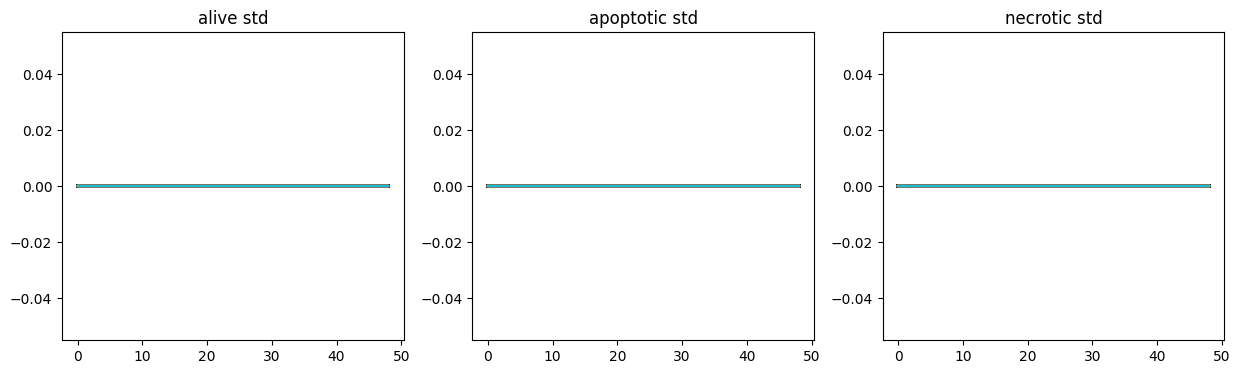

In [19]:
_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg[f'{cs}_mean']:
        axs[i].plot(a)
    axs[i].set_title(f'{cs} mean')
plt.show()

_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg[f'{cs}_median']:
        axs[i].plot(a)
    axs[i].set_title(f'{cs} median')
plt.show()

_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg[f'{cs}_std']:
        axs[i].plot(a)
    axs[i].set_title(f'{cs} std')
plt.show()

#### "diff" cell states statistics

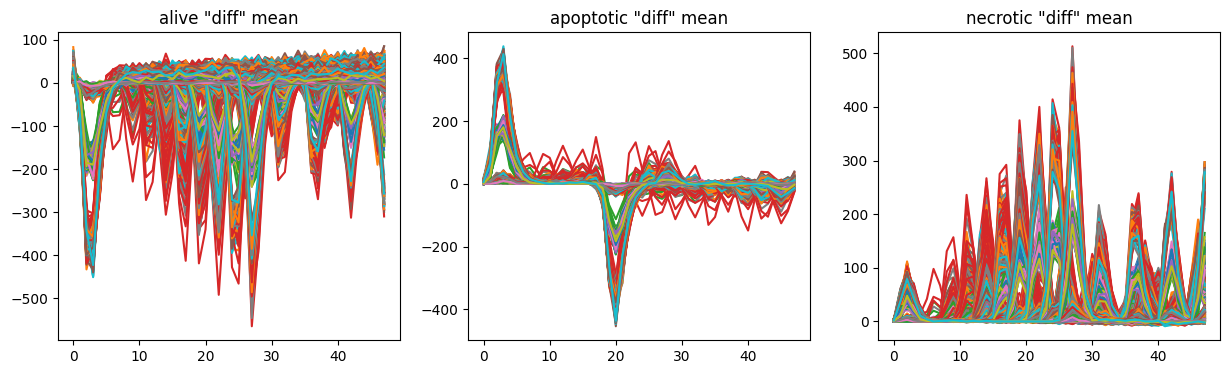

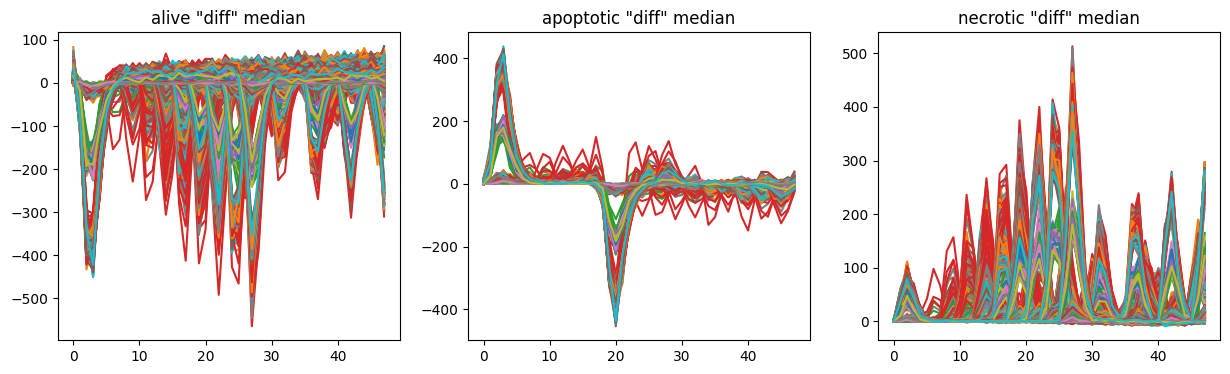

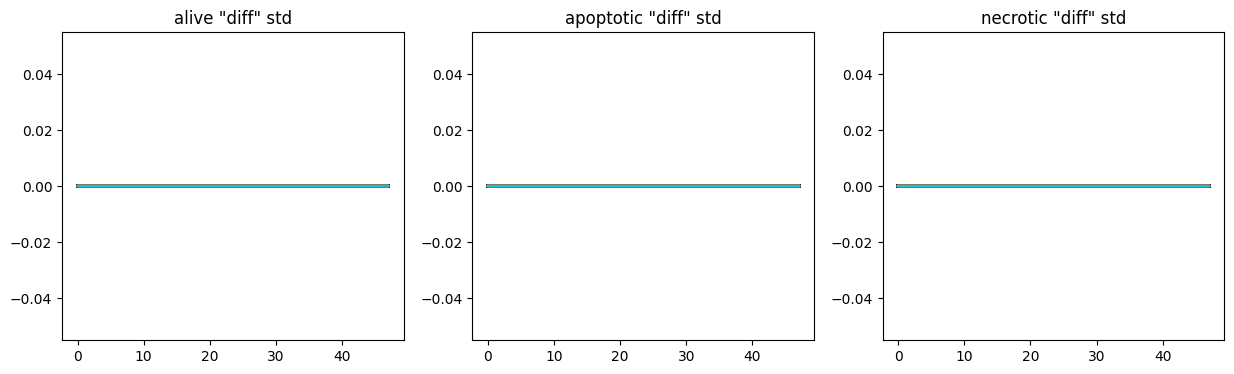

In [20]:
_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg_diff[f'{cs}_diff_mean']:
        axs[i].plot(a[1:])
    axs[i].set_title(f'{cs} "diff" mean')
plt.show()

_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg_diff[f'{cs}_diff_median']:
        axs[i].plot(a[1:])
    axs[i].set_title(f'{cs} "diff" median')
plt.show()

_, axs = plt.subplots(1, len(cell_states), figsize=(15, 4))
for i, cs in enumerate(cell_states):
    for a in data_agg_diff[f'{cs}_diff_std']:
        axs[i].plot(a[1:])
    axs[i].set_title(f'{cs} "diff" std')
plt.show()